In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.colors import ListedColormap
import folium
from folium.plugins import MarkerCluster,HeatMap,HeatMapWithTime
import branca.colormap as colormap
from collections import defaultdict

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [110]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [111]:
RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# tf.random.set_seed(7)
np.random.seed(42)
tf.random.set_seed(42)

In [112]:
df_latlong = pd.read_csv('countries.csv')

In [113]:
df_latlong.drop(['Importance', 'Altitude'], axis=1, inplace=True)
df_latlong.head().T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Latitude,33.768,41,28,42.5407,-11.8776
Longitude,66.2385,20,2.99998,1.5732,17.5691


In [114]:
df_gdp = pd.read_csv('gdp_per_capita.csv')

In [115]:
df_gdp.drop(['Unnamed: 65', 'Code'], axis=1, inplace=True)

In [116]:
df_gdp.head().T

,0,1,2,3,4
Country Name,Aruba,Africa Eastern and Southern,Afghanistan,Africa Western and Central,Angola
1960,NaN,147.612,59.7732,107.932,NaN
1961,NaN,147.015,59.8609,113.082,NaN
1962,NaN,156.189,58.458,118.831,NaN
1963,NaN,182.244,78.7064,123.443,NaN
...,...,...,...,...,...
2016,28452.2,1431.78,512.013,1673.84,3506.07
2017,29350.8,1573.06,516.68,1613.47,4095.81
2018,30253.3,1574.98,485.668,1704.14,3289.64
2019,NaN,1530.06,494.179,1777.92,2809.63


In [117]:
countries_df_latlong = df_latlong['Country'].values
countries_df_gdp = df_gdp['Country Name'].values

mismatch = [i for i in countries_df_latlong if i not in countries_df_gdp]

print(
"countries_df_latlong: ",len(countries_df_latlong),
"\n\ncountries_df_gdp: ",len(countries_df_gdp),
"\n\nmismatch: ",len(mismatch),
"\n\nmismatch countries:", mismatch
)

countries_df_latlong:  184 

countries_df_gdp:  266 

mismatch:  25 

mismatch countries: ['Bahamas', 'Brunei', 'Burma', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Czechia', 'Diamond Princess', 'Egypt', 'Gambia', 'Holy See', 'Iran', 'Korea, South', 'Kyrgyzstan', 'Laos', 'MS Zaandam', 'Russia', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Slovakia', 'Syria', 'Taiwan*', 'US', 'Venezuela', 'Western Sahara']


In [118]:
#### Depois fazer a correspondencia certinha
nodes = set(countries_df_latlong)-set(mismatch)
len(nodes)

159

In [119]:
nodes_df = [i for i in nodes]
df = df_latlong[df_latlong['Country'].isin(nodes_df)]
df.head(5).T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Latitude,33.768,41,28,42.5407,-11.8776
Longitude,66.2385,20,2.99998,1.5732,17.5691


In [120]:
df = pd.merge(df_latlong,df_gdp,how='inner',left_on=['Country'],right_on=['Country Name'])

df.drop(['Country Name'], axis=1, inplace=True)
df = df.rename({'Latitude': 'Lat', 'Longitude': 'Lon'}, axis=1)  # new method

df.head().T


,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Lat,33.768,41,28,42.5407,-11.8776
Lon,66.2385,20,2.99998,1.5732,17.5691
1960,59.7732,NaN,246.304,NaN,NaN
1961,59.8609,NaN,214.772,NaN,NaN
...,...,...,...,...,...
2016,512.013,4124.06,3946.45,37475.6,3506.07
2017,516.68,4531.02,4109.7,38964.9,4095.81
2018,485.668,5287.66,4142.02,41792,3289.64
2019,494.179,5395.66,3989.67,40897.3,2809.63


In [121]:
df.columns

Index(['Country', 'Lat', 'Lon', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'],
      dtype='object')

array([[<AxesSubplot:title={'center':'Lat'}>,
        <AxesSubplot:title={'center':'Lon'}>,
        <AxesSubplot:title={'center':'1960'}>,
        <AxesSubplot:title={'center':'1961'}>,
        <AxesSubplot:title={'center':'1962'}>,
        <AxesSubplot:title={'center':'1963'}>,
        <AxesSubplot:title={'center':'1964'}>,
        <AxesSubplot:title={'center':'1965'}>],
       [<AxesSubplot:title={'center':'1966'}>,
        <AxesSubplot:title={'center':'1967'}>,
        <AxesSubplot:title={'center':'1968'}>,
        <AxesSubplot:title={'center':'1969'}>,
        <AxesSubplot:title={'center':'1970'}>,
        <AxesSubplot:title={'center':'1971'}>,
        <AxesSubplot:title={'center':'1972'}>,
        <AxesSubplot:title={'center':'1973'}>],
       [<AxesSubplot:title={'center':'1974'}>,
        <AxesSubplot:title={'center':'1975'}>,
        <AxesSubplot:title={'center':'1976'}>,
        <AxesSubplot:title={'center':'1977'}>,
        <AxesSubplot:title={'center':'1978'}>,
        <Axes

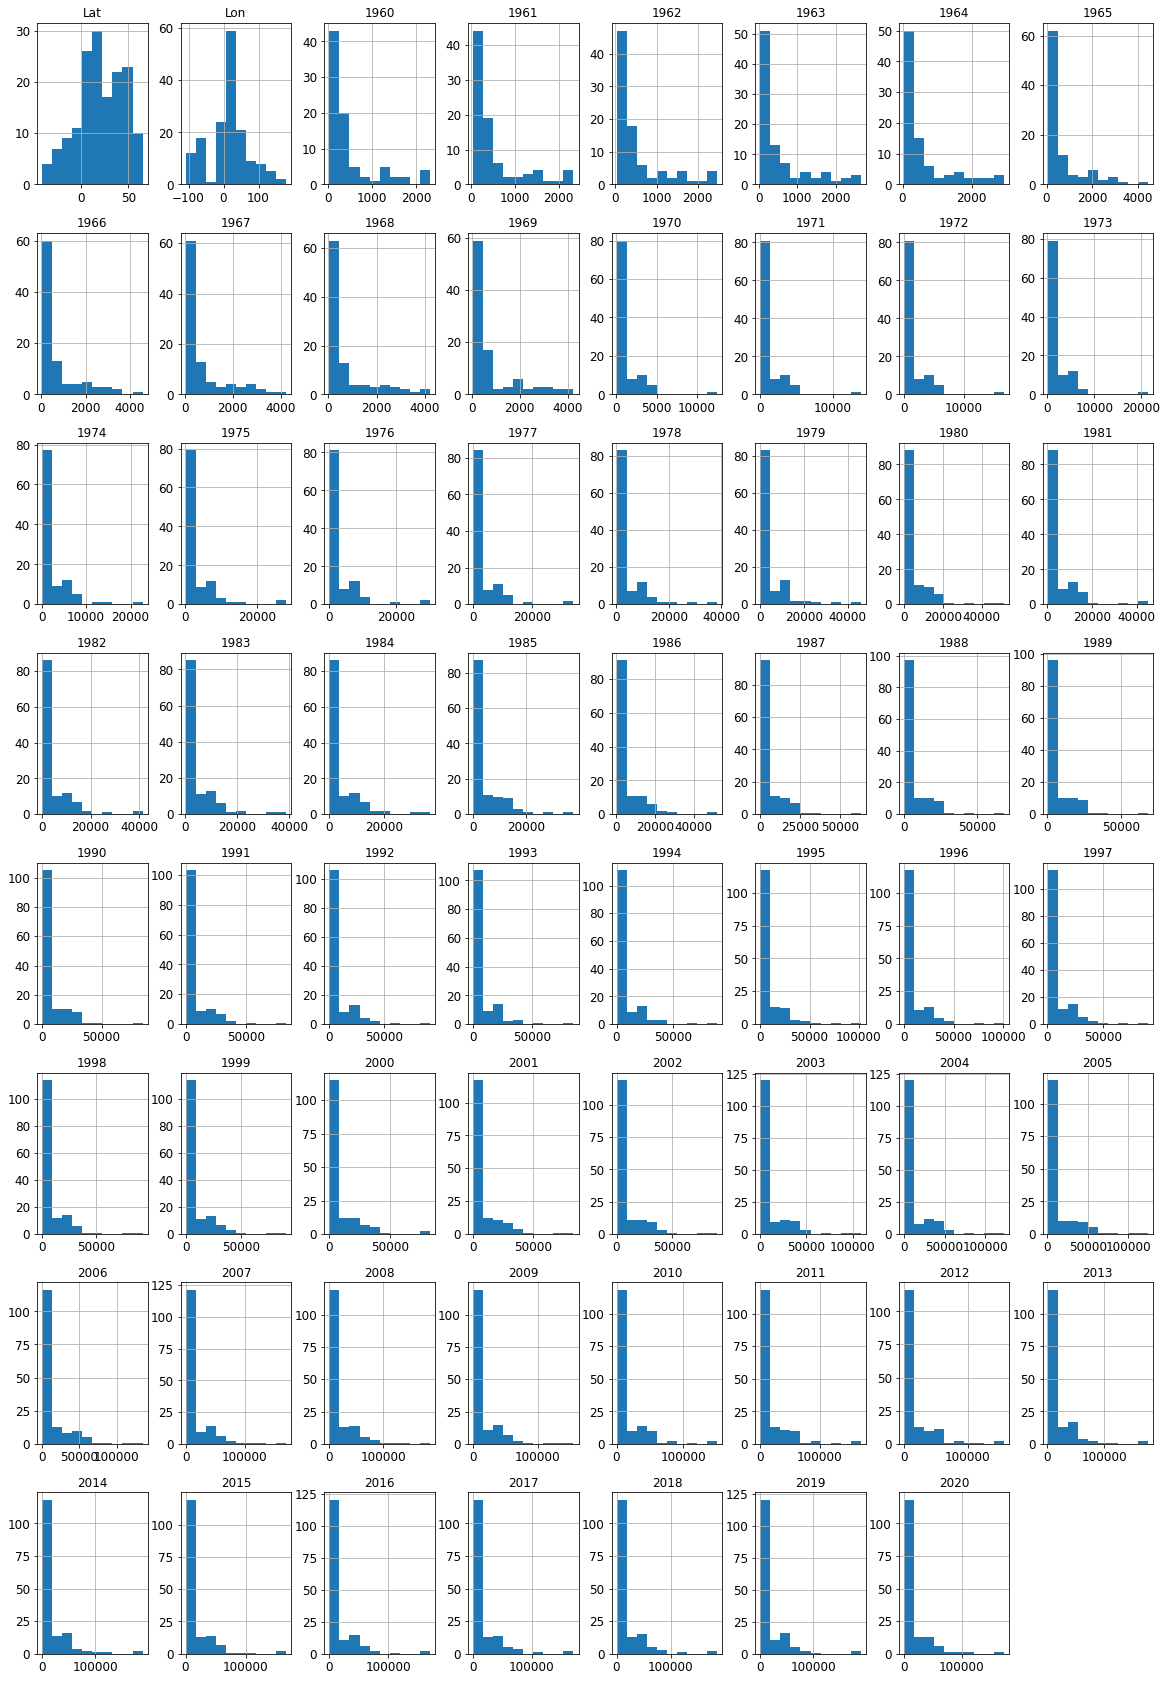

In [122]:
df.hist(figsize=(20,30))

In [125]:
GDP_years = list(set(df.columns) - {'Country', 'Lat', 'Lon'})

In [126]:
for column in GDP_years:
    df[column] = np.log10(df[column])

array([[<AxesSubplot:title={'center':'Lat'}>,
        <AxesSubplot:title={'center':'Lon'}>,
        <AxesSubplot:title={'center':'1960'}>,
        <AxesSubplot:title={'center':'1961'}>,
        <AxesSubplot:title={'center':'1962'}>,
        <AxesSubplot:title={'center':'1963'}>,
        <AxesSubplot:title={'center':'1964'}>,
        <AxesSubplot:title={'center':'1965'}>],
       [<AxesSubplot:title={'center':'1966'}>,
        <AxesSubplot:title={'center':'1967'}>,
        <AxesSubplot:title={'center':'1968'}>,
        <AxesSubplot:title={'center':'1969'}>,
        <AxesSubplot:title={'center':'1970'}>,
        <AxesSubplot:title={'center':'1971'}>,
        <AxesSubplot:title={'center':'1972'}>,
        <AxesSubplot:title={'center':'1973'}>],
       [<AxesSubplot:title={'center':'1974'}>,
        <AxesSubplot:title={'center':'1975'}>,
        <AxesSubplot:title={'center':'1976'}>,
        <AxesSubplot:title={'center':'1977'}>,
        <AxesSubplot:title={'center':'1978'}>,
        <Axes

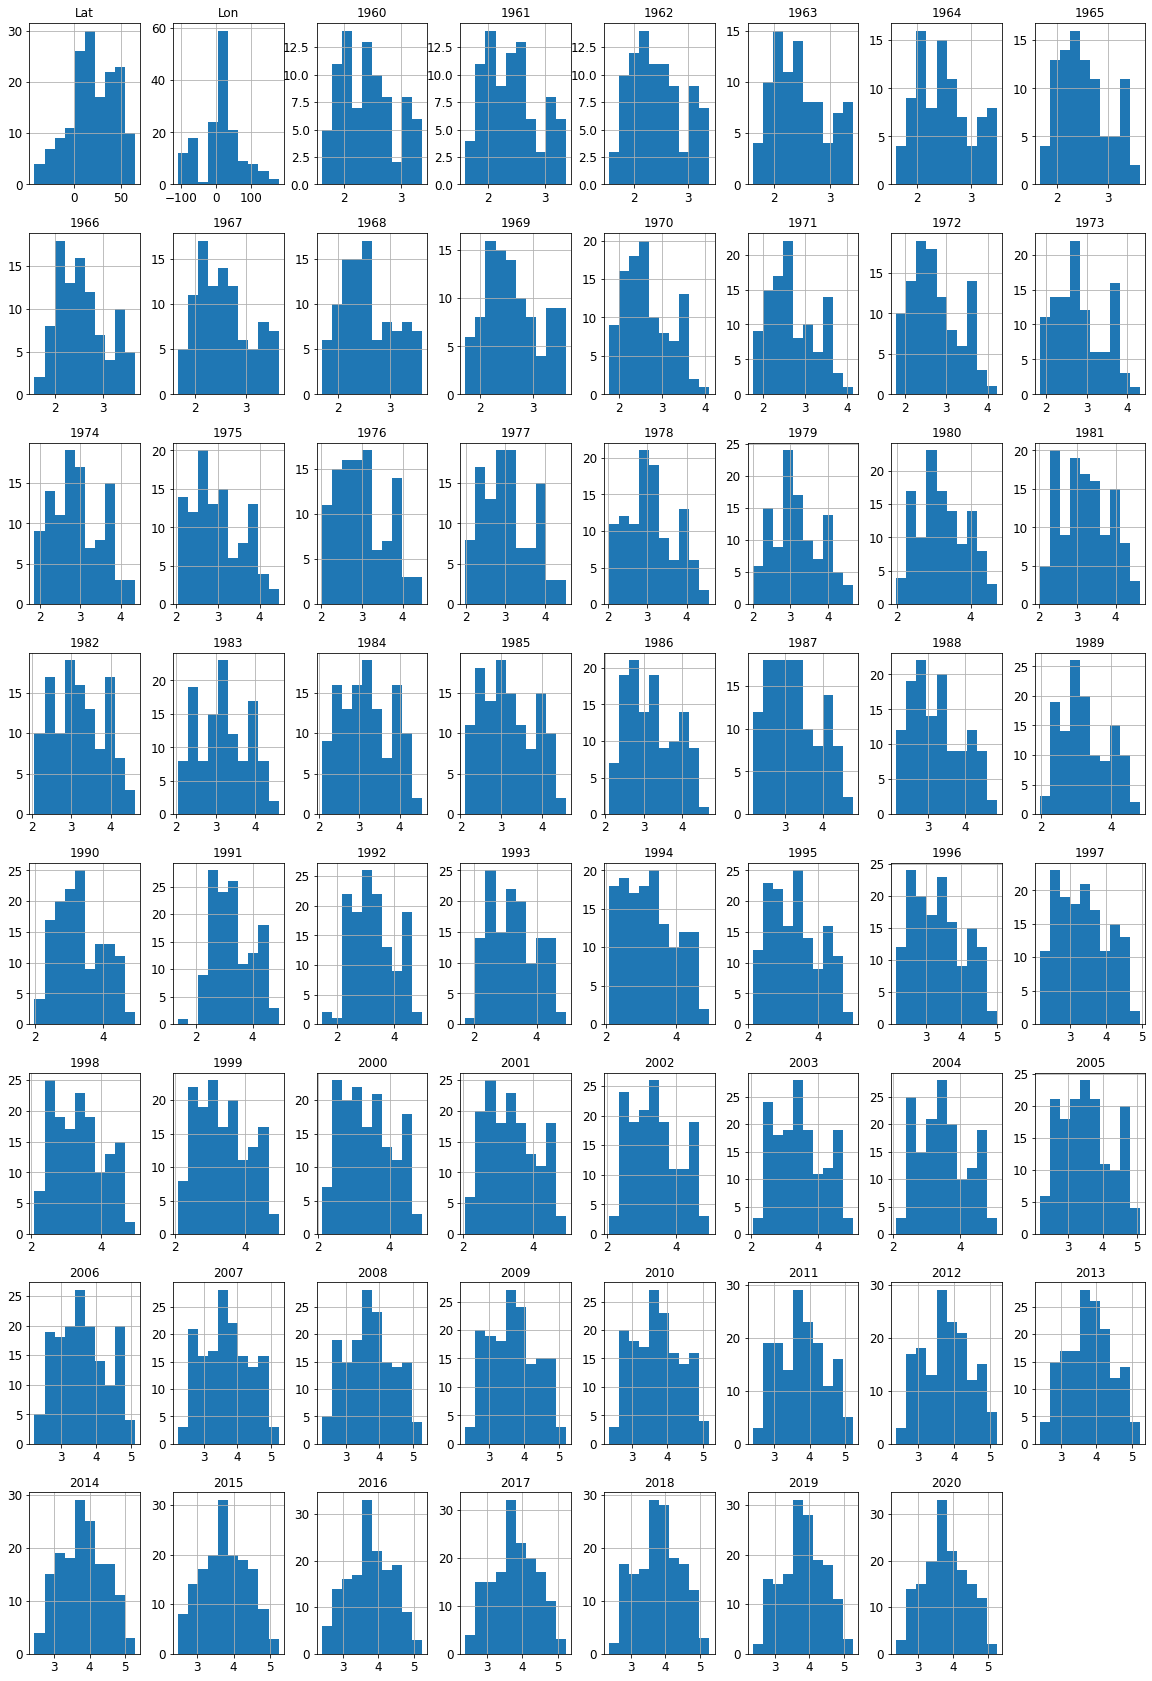

In [127]:
df.hist(figsize=(20,30))

In [128]:
# Load the xlsx file
excel_data = pd.read_excel('data_gdp_coordinates.xlsx')
# Read the values of the file in the dataframe
data = pd.DataFrame(excel_data)
del data["Unnamed: 0"]
data.describe()

,Ano,GDP,Lat,Lon
count,12504.000000,9.790000e+03,12504.000000,12504.000000
mean,1990.002399,1.924766e+11,18.961356,16.605233
std,17.606181,9.748143e+11,24.155906,69.694673
min,1960.000000,8.824448e+06,-40.900557,-175.198242
25%,1975.000000,1.635194e+09,3.919305,-9.696645
50%,1990.000000,8.865695e+09,17.607789,18.643501
75%,2005.000000,5.976397e+10,39.947180,46.869107
max,2020.000000,2.143322e+13,71.706936,179.414413


In [129]:
df.columns

Index(['Country', 'Lat', 'Lon', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020'],
      dtype='object')

In [130]:
df = df.melt(id_vars=['Country', 'Lat', 'Lon'], 
        var_name="Year", 
        value_name="GDP")

In [131]:
df.groupby("Country")['GDP'].count()

Country
Afghanistan           41
Albania               37
Algeria               61
Andorra               50
Angola                38
                      ..
Uzbekistan            31
Vietnam               36
West Bank and Gaza    27
Zambia                61
Zimbabwe              61
Name: GDP, Length: 159, dtype: int64

In [132]:
data = df.copy()

In [133]:
data.describe()

,Lat,Lon,GDP
count,9699.000000,9699.000000,7944.000000
mean,19.992953,15.263292,3.302753
std,24.147219,56.528889,0.759844
min,-41.500083,-107.991707,1.357846
25%,4.706435,-7.889626,2.694405
50%,18.115296,19.015617,3.252151
75%,41.323730,38.652120,3.862819
max,64.984182,179.012274,5.277580


In [134]:
data.notna().sum()

Country    9699
Lat        9699
Lon        9699
Year       9699
GDP        7944
dtype: int64

In [135]:
all_data=data.dropna(subset=['Lat','Lon'])

C:\Users\User\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

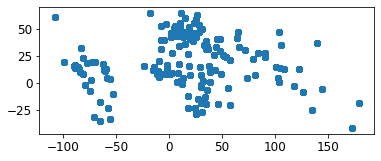

In [136]:
# Convert it to a GeoDataFrame by transforming the Latitude/Longitude coordinates 
loc_crs = {'init': 'epsg:4326'}
loc_geom = [Point(xy) for xy in zip(all_data['Lon'], all_data['Lat'])]
geo_df = gpd.GeoDataFrame(all_data, crs=loc_crs, geometry=loc_geom)

# Plot the GeoDataFrame
geo_df.plot()

In [137]:
del all_data['geometry']
colunas = all_data.columns.tolist()

In [138]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    # for x in unique_list:
    #     print (x)
    return unique_list
lista_unica = unique(all_data['Country'].tolist())       
# all_data['Pais'].tolist()

In [139]:
all_data

,Country,Lat,Lon,Year,GDP
0,Afghanistan,33.768006,66.238514,1960,1.776507
1,Albania,41.000028,19.999962,1960,NaN
2,Algeria,28.000027,2.999983,1960,2.391471
3,Andorra,42.540717,1.573203,1960,NaN
4,Angola,-11.877577,17.569124,1960,NaN
...,...,...,...,...,...
9694,Uzbekistan,41.323730,63.952810,2020,3.243211
9695,Vietnam,13.290403,108.426511,2020,3.444938
9696,West Bank and Gaza,31.433166,34.377928,2020,3.510509
9697,Zambia,-14.518624,27.559916,2020,2.993495


In [140]:
import math
dataset = []
for pais in lista_unica:
   data_pais = all_data[all_data["Pais"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   linha = 0
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
 
   while linha<len(gdp)-3: 
    #  dataset_array = []
    
     gdp_1 = gdp[linha:linha+1]
     gdp_2 = gdp[linha+1:linha+2]
     gdp_3 = gdp[linha+2:linha+3]
     gdp_4 = gdp[linha+3:linha+4]
     gdp_5 = gdp[linha+4:linha+5]

    #  print("gdp_1 {0}".format(gdp_1))
    #  print("gdp_2 {0}".format(gdp_2))
    #  print("gdp_3 {0}".format(gdp_3))
    #  print("gdp_4 {0}".format(gdp_4))
    #  print("gdp_5 {0}".format(gdp_5))
     if math.isnan(gdp_1[0]) or math.isnan(gdp_2[0]) or math.isnan(gdp_3[0]) or math.isnan(gdp_4[0]) or math.isnan(gdp_5[0]):
       nan = 0
      #  print(gdp_1[0])
      #  print("nan")
     else:
       dataset.append([latitude_pais])
       dataset.append([longitude_pais])
       dataset.append(gdp_1)
       dataset.append(gdp_2)
       dataset.append(gdp_3)
       dataset.append(gdp_4)
       dataset.append(gdp_5)

      
      # dataset.append(dataset_array)
     linha +=4

print(dataset)    


KeyError: 'Pais'

In [ ]:
import math
dataset = []
for pais in lista_unica:
   data_pais = all_data[all_data["Country"] == pais]
   latitude_pais = data_pais.Lat
   latitude_pais = latitude_pais.tolist()
   latitude_pais = latitude_pais[0]
   longitude_pais = data_pais.Lon
   longitude_pais = longitude_pais.tolist()
   longitude_pais = longitude_pais[0]
   linha = 0
   gdp =  data_pais.GDP
   gdp = gdp.tolist()
 
   while linha<len(gdp)-3: 
    #  dataset_array = []
    
     gdp_1 = gdp[linha]
     gdp_2 = gdp[linha+1]
     gdp_3 = gdp[linha+2]
     gdp_4 = gdp[linha+3]
     gdp_5 = gdp[linha+4]

    #  print("gdp_1 {0}".format(gdp_1))
    #  print("gdp_2 {0}".format(gdp_2))
    #  print("gdp_3 {0}".format(gdp_3))
    #  print("gdp_4 {0}".format(gdp_4))
    #  print("gdp_5 {0}".format(gdp_5))
     if math.isnan(gdp_1) or math.isnan(gdp_2) or math.isnan(gdp_3) or math.isnan(gdp_4) or math.isnan(gdp_5):
       nan = 0
      #  print(gdp_1[0])
      #  print("nan")
     else:
       dataset.append([latitude_pais, longitude_pais, gdp_1, gdp_2, gdp_3, gdp_4, gdp_5])

      
      # dataset.append(dataset_array)
     linha +=4

print(dataset)    


In [ ]:
my_array = np.array(dataset)
dataset = my_array.astype('float32')
# Normalizando os Valores
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


In [ ]:
# lista=[]
# data=[]
# contador=0
# for l in dataset:
#   # print(l[0])
#   lista.append([l[0]])
#   contador +=1
#   if contador ==7:
#     # print(lista)
#     data.append(lista)
#     lista=[]
#     contador=0
  
# my_array = np.array(data)
# dataset = my_array.astype('float32')
# # dataset

In [ ]:
n_steps = 6 #CADA LISTA DENTRO DA LISTA VAI TER 7 DADOS

setenta_porc= int((70*len(dataset))/100)
vint_poc = int((20*len(dataset))/100)
nov_porc=setenta_porc+vint_poc

X_train, y_train = dataset[:setenta_porc, :n_steps], dataset[:setenta_porc, -1]
X_valid, y_valid = dataset[setenta_porc:nov_porc, :n_steps], dataset[setenta_porc:nov_porc, -1]
X_test, y_test = dataset[nov_porc:, :n_steps], dataset[nov_porc:, -1]

In [ ]:
X_train

In [ ]:
X_train.shape, y_train.shape

Saving figure time_series_plot


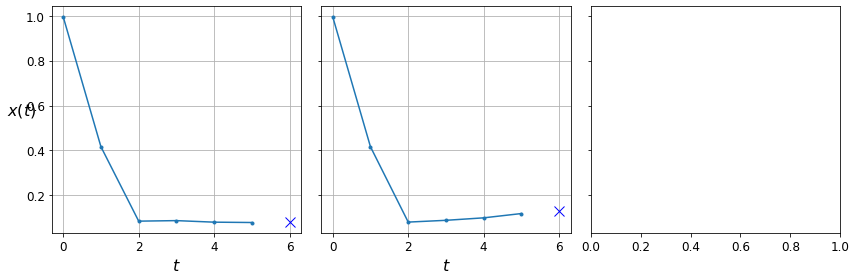

In [141]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    # plt.hlines(0, 0, 100, linewidth=1)
    # plt.axis([0, n_steps + 1, -1, 1])


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(2):
    plt.sca(axes[col])
    plot_series(
        X_valid[col, :],
        y_valid[col],
        y_label=("$x(t)$" if col == 0 else None),
    )
save_fig("time_series_plot")
plt.show()

In [142]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.00014079157

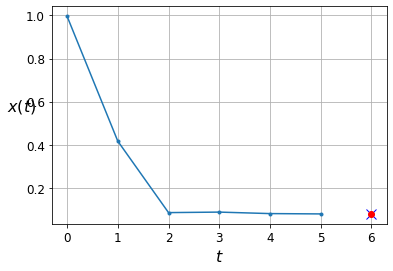

In [143]:
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.show()

In [144]:


model = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=[6, 1]),
    keras.layers.Dense(1,input_shape=[6]),
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=128, #128
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
11/11 [==============================] - 1s 27ms/step - loss: 0.0268 - val_loss: 0.0174
Epoch 2/80
11/11 [==============================] - 0s 9ms/step - loss: 0.0171 - val_loss: 0.0100
Epoch 3/80
11/11 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0059
Epoch 4/80
11/11 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 5/80
11/11 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 6/80
11/11 [==============================] - 0s 7ms/step - loss: 0.0017 - val_loss: 8.9818e-04
Epoch 7/80
11/11 [==============================] - 0s 6ms/step - loss: 8.8643e-04 - val_loss: 5.8673e-04
Epoch 8/80
11/11 [==============================] - 0s 7ms/step - loss: 5.2202e-04 - val_loss: 3.8275e-04
Epoch 9/80
11/11 [==============================] - 0s 7ms/step - loss: 3.3018e-04 - val_loss: 3.0125e-04
Epoch 10/80
11/11 [==============================] - 0s 6ms/step - loss: 2.3991e-04 - val

Epoch 78/80
11/11 [==============================] - 0s 15ms/step - loss: 1.1864e-04 - val_loss: 1.6021e-04
Epoch 79/80
11/11 [==============================] - 0s 18ms/step - loss: 1.1857e-04 - val_loss: 1.5801e-04
Epoch 80/80
11/11 [==============================] - 0s 15ms/step - loss: 1.1603e-04 - val_loss: 1.5710e-04


In [145]:
model.evaluate(X_valid, y_valid) #Erro medio quadratico

12/12 [==============================] - 0s 3ms/step - loss: 1.5710e-04


0.00015710273873992264

In [146]:
model.layers[0].get_weights()

[array([[ 4.7753481e-03],
        [ 8.8967069e-04],
        [ 2.8130781e-02],
        [ 3.3254007e-01],
        [-3.4702471e-01],
        [ 1.0069396e+00]], dtype=float32),
 array([-0.00225587], dtype=float32)]

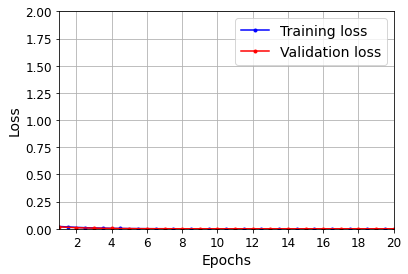

In [147]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(
        np.arange(len(val_loss)) + 1,
        val_loss,
        "r.-",
        label="Validation loss",
    )
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 2])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

12/12 [==============================] - 0s 4ms/step


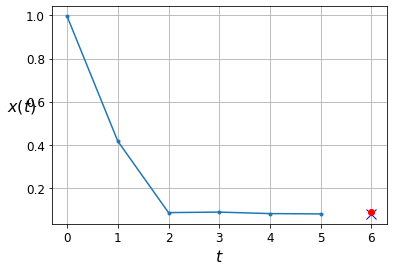

In [148]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.show()

Simple RNN

In [149]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]),
])

In [150]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train,
    epochs=80, #20
    batch_size=20, #180
    validation_data=(X_valid, y_valid),
)

Epoch 1/80
67/67 [==============================] - 3s 10ms/step - loss: 0.0158 - val_loss: 0.0088
Epoch 2/80
67/67 [==============================] - 0s 5ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 3/80
67/67 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 4/80
67/67 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 5/80
67/67 [==============================] - 0s 6ms/step - loss: 8.5771e-04 - val_loss: 4.3103e-04
Epoch 6/80
67/67 [==============================] - 0s 6ms/step - loss: 3.9128e-04 - val_loss: 1.6650e-04
Epoch 7/80
67/67 [==============================] - 0s 7ms/step - loss: 2.2927e-04 - val_loss: 1.1787e-04
Epoch 8/80
67/67 [==============================] - 1s 9ms/step - loss: 1.8284e-04 - val_loss: 9.8070e-05
Epoch 9/80
67/67 [==============================] - 1s 8ms/step - loss: 1.7034e-04 - val_loss: 1.0080e-04
Epoch 10/80
67/67 [==============================] - 1s 7ms/step - loss: 1.66

In [ ]:
model.evaluate(X_valid, y_valid) #

In [ ]:
model.layers[0].get_weights()

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :], y_valid[0], y_pred[0])
plt.show()